In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import LSTM, Dense
from keras.layers import GRU 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [2]:
exchange_data = pd.read_csv('GBPUSD-4HOUR.csv')
exchange_data.head()

,time,open,high,low,close,Volume,Volume MA
0,2009-12-31T22:00:00Z,1.617570,1.617570,1.615630,1.615630,8,NaN
1,2010-01-03T22:00:00Z,1.611220,1.615290,1.609180,1.609230,4115,NaN
2,2010-01-04T02:00:00Z,1.609230,1.612080,1.607350,1.609630,2782,NaN
3,2010-01-04T06:00:00Z,1.609630,1.621375,1.605795,1.620535,7412,NaN
4,2010-01-04T10:00:00Z,1.620535,1.624185,1.613925,1.616265,8100,NaN


In [3]:
exchange_data["time"] = pd.to_datetime(exchange_data["time"])
ind_exchange_data = exchange_data.set_index(["time"], drop=True)
ind_exchange_data.head()

,open,high,low,close,Volume,Volume MA
time,,,,,,
2009-12-31 22:00:00+00:00,1.617570,1.617570,1.615630,1.615630,8,NaN
2010-01-03 22:00:00+00:00,1.611220,1.615290,1.609180,1.609230,4115,NaN
2010-01-04 02:00:00+00:00,1.609230,1.612080,1.607350,1.609630,2782,NaN
2010-01-04 06:00:00+00:00,1.609630,1.621375,1.605795,1.620535,7412,NaN
2010-01-04 10:00:00+00:00,1.620535,1.624185,1.613925,1.616265,8100,NaN


In [4]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=False)

cut_off_date = pd.Timestamp('22-05-22')
data_frame = data_frame.loc[:cut_off_date]
clipped_length = len(data_frame)
data_frame.tail(10)

/var/folders/qs/tq01j0l577ddz8gg_tnvhl6m0000gn/T/ipykernel_40735/4232442468.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  data_frame = data_frame.loc[:cut_off_date]


,open,low,high,close,Volume MA,Volume
time,,,,,,
2022-05-19 05:00:00+00:00,1.23864,1.23378,1.24077,1.23918,32155.10,42788
2022-05-19 09:00:00+00:00,1.23918,1.23696,1.24381,1.24292,33082.85,48980
2022-05-19 13:00:00+00:00,1.24292,1.24264,1.25248,1.24984,35075.50,77473
2022-05-19 17:00:00+00:00,1.24984,1.24710,1.25122,1.24713,35395.15,37673
2022-05-19 21:00:00+00:00,1.24713,1.24510,1.24844,1.24637,33937.35,15466
2022-05-20 01:00:00+00:00,1.24637,1.24370,1.24696,1.24544,34148.55,26153
2022-05-20 05:00:00+00:00,1.24544,1.24480,1.24968,1.24868,35528.95,39773
2022-05-20 09:00:00+00:00,1.24868,1.24614,1.24908,1.24784,36202.25,31684
2022-05-20 13:00:00+00:00,1.24784,1.24526,1.25004,1.24721,36749.65,52058


In [5]:
print("The length of the original dataset it", len(ind_exchange_data))
print("The length of the clipped dataset is", len(data_frame))

The length of the original dataset it 20438
The length of the clipped dataset is 19270


<AxesSubplot: xlabel='time'>

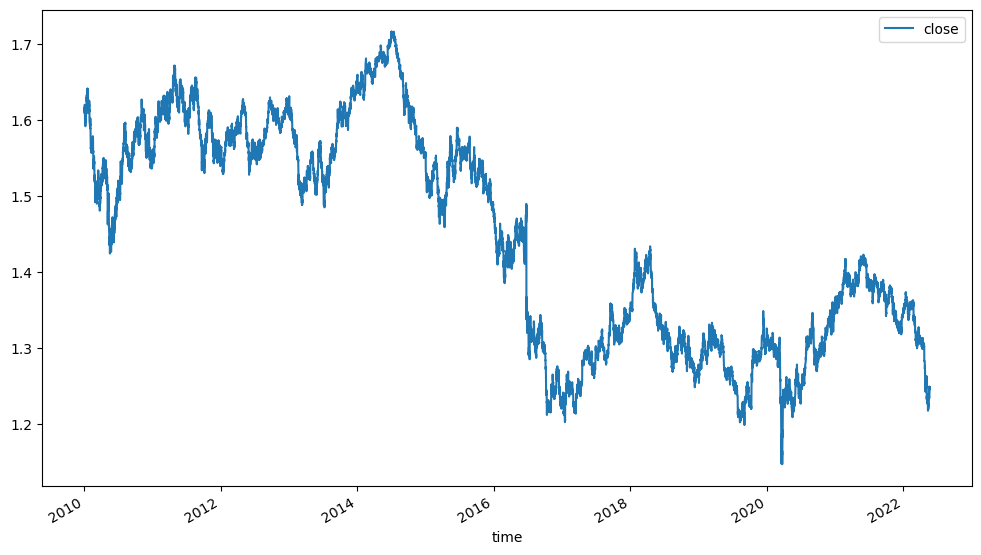

In [6]:
df = data_frame[["close"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [7]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 12 years
80 percent data = 2010 to 2019


In [8]:
df.describe()

,close
count,19270.000000
mean,1.445136
std,0.142216
min,1.147640
25%,1.309480
50%,1.441470
75%,1.572085
max,1.717000


In [9]:
#deduce where the number where the partition should be made 

adjust_data_frame = np.array(data_frame)
x = int(len(data_frame))
split_length = int(x * 0.8)
#You need find the data where the training and testing will be split
split_date = data_frame.index[split_length]



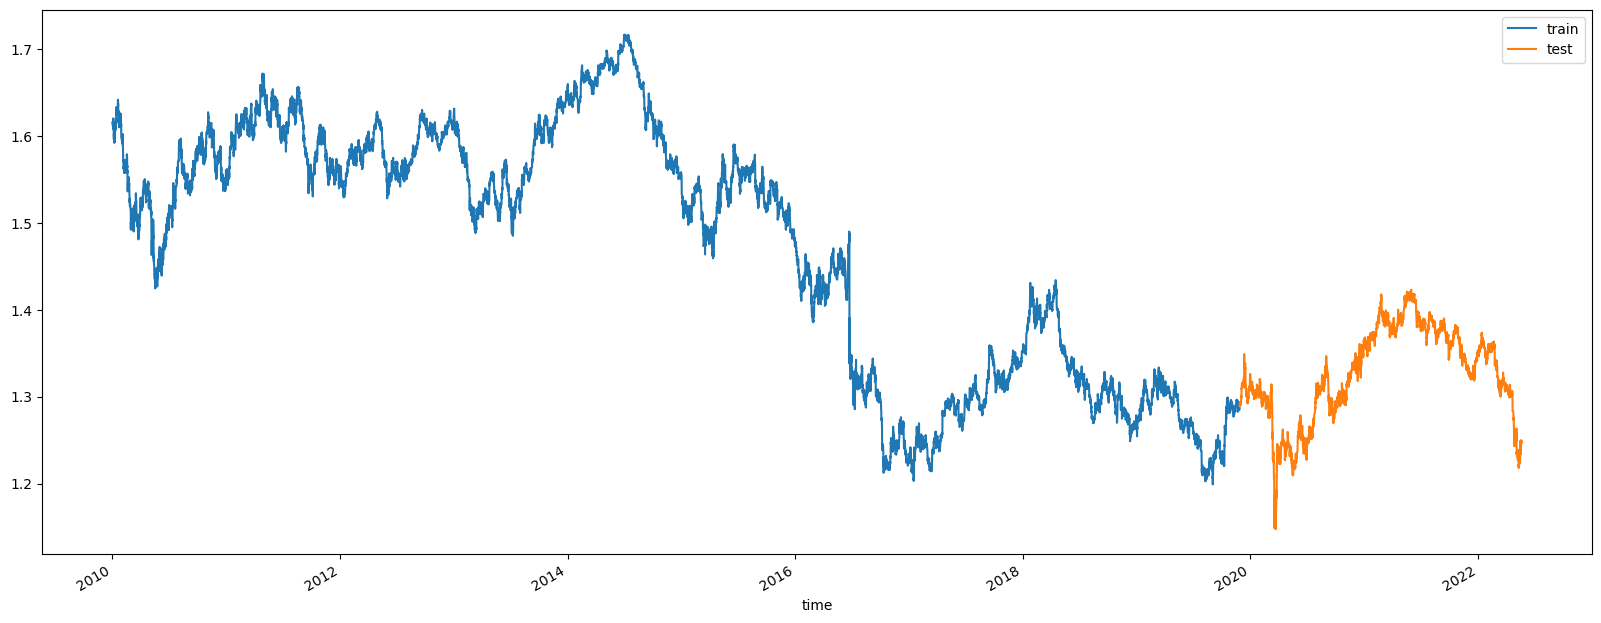

In [10]:
train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(20,8))
test.plot(ax=ax,kind='line',figsize=(20,8))
plt.legend(['train', 'test'])

In [11]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]


In [13]:
X = []
y = []
timesteps = 6

for i in range(timesteps, train.shape[0]):
    X.append(train_sc[i-timesteps:i, 0])
    y.append(train_sc[i, 0])



X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(X.shape)
print(y.shape)






(15411, 6, 1)
(15411,)


In [14]:
K.clear_session()

#model_lstm = tf.keras.Sequential([
#    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)),
#    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
#    tf.keras.layers.MaxPooling1D(pool_size=2),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(units=64, activation='relu'),
#    tf.keras.layers.Dense(units=1, activation='linear')
#])


#Convolutional followed by lstm does pretty for short term predictions, this one got the n+1 iteration perfectly right 

#model_lstm = tf.keras.Sequential([
#    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)),
#    tf.keras.layers.MaxPooling1D(pool_size=2),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.LSTM(50, return_sequences=True),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(units=1, activation='linear')
#])


#LSTM GRU CNN




model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(104, return_sequences=True, input_shape=(6, 1)),
    tf.keras.layers.GRU(49, return_sequences=True),
    tf.keras.layers.Conv1D(filters=76, kernel_size=4, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='linear')
    ])


#def create_model(lstm_nodes, gru_nodes, num_filters, kernel_size, dropout_size):
#    model_lstm = tf.keras.Sequential([
#        tf.keras.layers.LSTM(lstm_nodes, return_sequences=True, input_shape=(6, 1)),
#        tf.keras.layers.GRU(gru_nodes, return_sequences=True),
#        tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
#        tf.keras.layers.MaxPooling1D(pool_size=2),
#        tf.keras.layers.Dropout(dropout_size),
#        tf.keras.layers.Flatten(),
#        tf.keras.layers.Dense(units=1, activation='linear')
#    ])
    
#    model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
#              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
    
#    return model_lstm




#We need to start looking at echo state networks 






In [ ]:
pbounds = {'lstm_nodes': (16, 256),
           'gru_nodes':(16, 256),
           'num_filters': (32, 128),
           'kernel_size': (3, 5),
           'dropout_size': (0, 0.5)}

In [ ]:
def bayesian_optimization_function(lstm_nodes, gru_nodes, num_filters,kernel_size,dropout_size):
    model = create_model(lstm_nodes=int(lstm_nodes),
                        gru_nodes = int(gru_nodes),
                        num_filters = int(num_filters),
                        kernel_size = int(kernel_size),
                        dropout_size =dropout_size)

   

    history = model_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])
    val_acc = history.history['rmse'][-1]

    return val_acc

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
optimizer = BayesianOptimization(
    f=bayesian_optimization_function,
    pbounds=pbounds,
    random_state=42
)

In [ ]:
optimizer.maximize(init_points=5, n_iter=10)

In [15]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm = model_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100


2023-04-15 00:09:23.903477: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


81/81 [==============================] - 3s 9ms/step - loss: 0.1130 - rmse: 0.3361
Epoch 2/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0332 - rmse: 0.1821
Epoch 3/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0212 - rmse: 0.1456
Epoch 4/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0184 - rmse: 0.1355
Epoch 5/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0168 - rmse: 0.1296
Epoch 6/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0154 - rmse: 0.1241
Epoch 7/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0147 - rmse: 0.1211
Epoch 8/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0162 - rmse: 0.1273
Epoch 9/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0162 - rmse: 0.1273
Epoch 10/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0141 - rmse: 0.1188
Epoch 11/100
81/81 [==============================] 

In [16]:
X_test_lstm = []
Y_test_lstm = []

for i in range(timesteps, test.shape[0]):
    X_test_lstm.append(test_sc[i-timesteps:i, 0])
    Y_test_lstm.append(test_sc[i, 0])

    
X_test_lstm = np.array(X_test_lstm)
Y_test_lstm = np.array(Y_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

y_pred_test_lstm = model_lstm.predict(X_test_lstm)





print(sc.inverse_transform(Y_test_lstm[-1].reshape(-1,1)))




121/121 [==============================] - 1s 1ms/step
[[1.24918]]


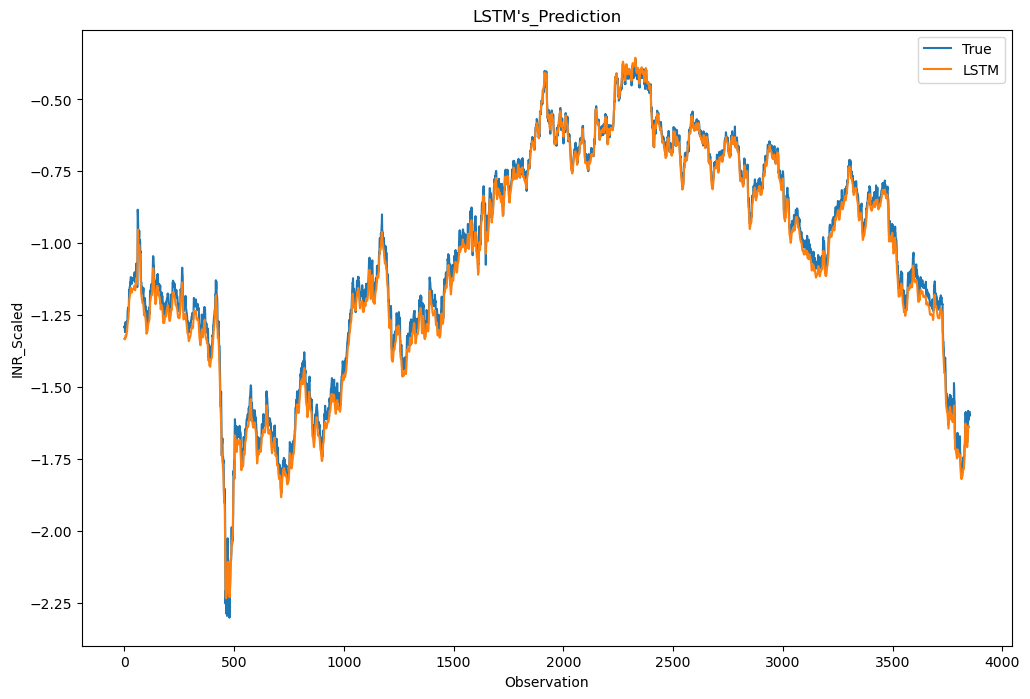

In [17]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [18]:
last_prediction = y_pred_test_lstm[-timesteps:]
last_prediction = np.array(last_prediction)

for i in range(10):
    next_input = np.array([last_prediction[-timesteps:]])
    next_input = next_input.reshape((next_input.shape[0], next_input.shape[1], 1))
    next_prediction = model_lstm.predict(next_input, verbose=0)
    last_prediction = np.append(last_prediction, next_prediction[0])
    

lstm_future = np.array(last_prediction[-10:]).reshape(-1,1)
inverse_transformed_data_lstm = sc.inverse_transform(lstm_future).flatten().tolist()
print(inverse_transformed_data_lstm)








[1.2334481477737427, 1.2352815866470337, 1.2359511852264404, 1.2354239225387573, 1.2339417934417725, 1.2319411039352417, 1.2303247451782227, 1.2304936647415161, 1.2297836542129517, 1.2285773754119873]


In [19]:
lstm_rounded_numbers = [round(x, 5) for x in inverse_transformed_data_lstm]

#The last predicted value from the lstm test data 
print(sc.inverse_transform(y_pred_test_lstm[-1:]))
#The next predicitons made by the model 
print(lstm_rounded_numbers)


#So in terms of prediction we have the very last of the testing data plus the new iterations 

[[1.2418321]]
[1.23345, 1.23528, 1.23595, 1.23542, 1.23394, 1.23194, 1.23032, 1.23049, 1.22978, 1.22858]


In [20]:
future_lstm_prices = []
last_lstm = sc.inverse_transform(y_pred_test_lstm[-1:])
future_lstm_prices.append(round(float(last_lstm[0]),5))
for x in lstm_rounded_numbers:
    future_lstm_prices.append(x) 

In [21]:
print(clipped_length)
future_comparison = ind_exchange_data.iloc[clipped_length-1:]
print(future_comparison.head(10))             

19270
                              open     high      low    close  Volume  \
time                                                                    
2022-05-20 17:00:00+00:00  1.24721  1.24970  1.24533  1.24918   29134   
2022-05-22 21:00:00+00:00  1.24918  1.25300  1.24795  1.25263   14233   
2022-05-23 01:00:00+00:00  1.25263  1.25534  1.25222  1.25460   18129   
2022-05-23 05:00:00+00:00  1.25460  1.25759  1.25412  1.25717   39832   
2022-05-23 09:00:00+00:00  1.25717  1.26010  1.25634  1.25676   36437   
2022-05-23 13:00:00+00:00  1.25676  1.25938  1.25562  1.25684   43402   
2022-05-23 17:00:00+00:00  1.25684  1.25888  1.25584  1.25879   18767   
2022-05-23 21:00:00+00:00  1.25879  1.25890  1.25568  1.25590   11758   
2022-05-24 01:00:00+00:00  1.25590  1.25696  1.25475  1.25606   16979   
2022-05-24 05:00:00+00:00  1.25606  1.25991  1.24750  1.24866   46084   

                           Volume MA  
time                                  
2022-05-20 17:00:00+00:00   35497.20  


In [22]:
future = future_comparison.iloc[0:11]

future_prices_table = future["close"]

future_prices = []
for x in future_prices_table:
    future_prices.append(x)

print(future_prices)

[1.24918, 1.25263, 1.2546, 1.25717, 1.25676, 1.25684, 1.25879, 1.2559, 1.25606, 1.24866, 1.2492]


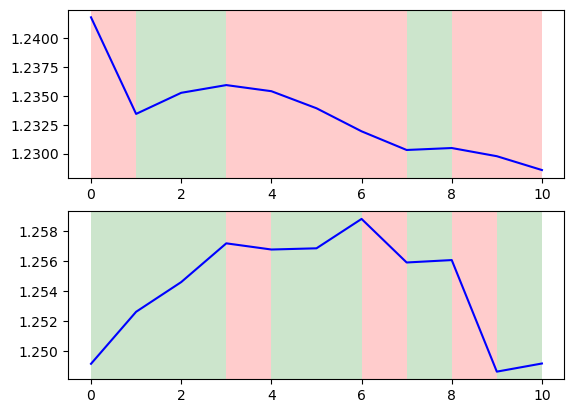

In [23]:

def classify_numbers(lst):
    classifications = []
    prev_num = lst[0]
    for i, num in enumerate(lst[1:], start=1):
        if num > prev_num:
            classifications.append('green')
        else:
            classifications.append('red')
        prev_num = num
    return classifications

classifications1 = classify_numbers(future_lstm_prices)
classifications2 = classify_numbers(future_prices)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(future_lstm_prices, color='blue')
for i, c in enumerate(classifications1):
    if c == 'green':
        ax1.axvspan(i, i+1, facecolor='green', alpha=0.2)
    elif c == 'red':
        ax1.axvspan(i, i+1, facecolor='red', alpha=0.2)

ax2.plot(future_prices, color='blue')
for i, c in enumerate(classifications2):
    if c == 'green':
        ax2.axvspan(i, i+1, facecolor='green', alpha=0.2)
    elif c == 'red':
        ax2.axvspan(i, i+1, facecolor='red', alpha=0.2)

plt.show()



#This may be potientally be abled to be used, it may have not got the correct retracements however it was able to predict the overall direction, 
#say you have had a fib at this level for a potiental buy this fib could be immediately discarded as it will be clear break through, we need to find a potiental change 
#in momentum to be able to predict this. Evaluation wise these model might do well in predictiing overall trend than proper values  




In [ ]:
#Things to do, you need to add different time frames, you also need to include different features 

In [ ]:

print(Y_test_lstm.shape)
print(y_pred_test_lstm.shape)


a = Y_test_lstm.flatten()
b = y_pred_test_lstm.flatten()


matches = 0
for i in range(len(a)-1):
    if (a[i+1] > a[i] and b[i+1] > b[i]) or (a[i+1] < a[i] and b[i+1] < b[i]):
        matches += 1
        

z = matches / (len(a)-1) * 100
print(z)


In [ ]:
#Evaluation section 
#Plot the loss function 
plt.plot(history_model_lstm.history['loss'], label='Training Loss')
plt.title('Forex Price Prediction Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
#Plot actual vs predicted 
plt.scatter(Y_test_lstm, y_pred_test_lstm, alpha=0.2)
plt.title('Forex Price Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume Y_test_lstm and y_pred_test_lstm are already defined

test_lstm_1D = Y_test_lstm.ravel()
pred_lstm_1D = y_pred_test_lstm.ravel()

# create a dataframe with the actual and predicted values
data = {'Actual Prices': test_lstm_1D, 'Predicted Prices': pred_lstm_1D}
df = pd.DataFrame(data)

# create a heatmap of the data
heatmap = sns.jointplot(data=df, x='Actual Prices', y='Predicted Prices', kind='hex', cmap='YlGnBu')

# set the plot title
heatmap.fig.suptitle('Forex Price Prediction', fontsize=10, fontweight='bold', y=1.05)
heatmap.fig.subplots_adjust(top=0.9)

# show the plot
plt.show()


In [ ]:
#Residuals 


Y_test_lstm = np.array(Y_test_lstm)
y_pred_test_lstm = np.ravel(y_pred_test_lstm)

print(Y_test_lstm.shape)
print(y_pred_test_lstm.shape)

residuals = Y_test_lstm - y_pred_test_lstm



# create a scatter plot of the predicted values vs. the residuals
plt.scatter(y_pred_test_lstm, residuals, alpha=0.5)

# add a horizontal line at y=0 to indicate zero residual
plt.axhline(y=0, color='red', linestyle='--')

# set the x-axis label
plt.xlabel('Predicted Prices')

# set the y-axis label
plt.ylabel('Residuals')

# set the plot title
plt.title('Forex Price Prediction Residual Plot')

# show the plot
plt.show()

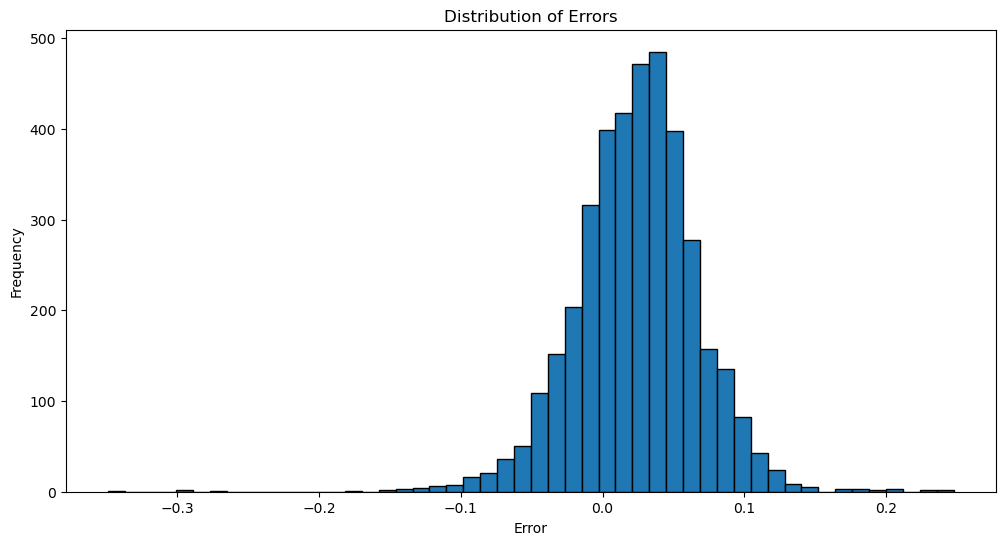

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# assume Y_test_lstm and y_pred_test_lstm are already defined

# calculate the errors between the actual and predicted values
errors = Y_test_lstm - y_pred_test_lstm.ravel()

# create a figure and axis object
fig, ax = plt.subplots(figsize=(12,6))

# create a histogram of the errors
ax.hist(errors, bins=50, edgecolor='black')

# set the x-axis label
ax.set_xlabel('Error')

# set the y-axis label
ax.set_ylabel('Frequency')

# set the plot title
ax.set_title('Distribution of Errors')

# show the plot
plt.show()
